In [1]:
from google.colab import files
uploaded = files.upload()

Saving sales.csv to sales.csv


In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")


In [4]:
# Load dataset
df = pd.read_csv("sales.csv")

# Parse dates
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d-%m-%Y')

# Handle missing values
df = df.dropna()

# Add time features
df['YearMonth'] = df['Order Date'].dt.to_period('M')
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,YearMonth,Year,Month
0,1,US-2021-103800,2021-01-03,2021-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512,2021-01,2021,1
1,2,US-2021-112326,2021-01-04,2021-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870,2021-01,2021,1
2,3,US-2021-112326,2021-01-04,2021-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717,2021-01,2021,1
3,4,US-2021-112326,2021-01-04,2021-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748,2021-01,2021,1
4,5,US-2021-141817,2021-01-05,2021-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840,2021-01,2021,1


In [6]:
# Create SQLite database
conn = sqlite3.connect("sales.db")

# Convert 'YearMonth' to string before writing to DB
df['YearMonth'] = df['YearMonth'].astype(str)

# Write dataframe to DB
df.to_sql("orders", conn, if_exists="replace", index=False)

10194

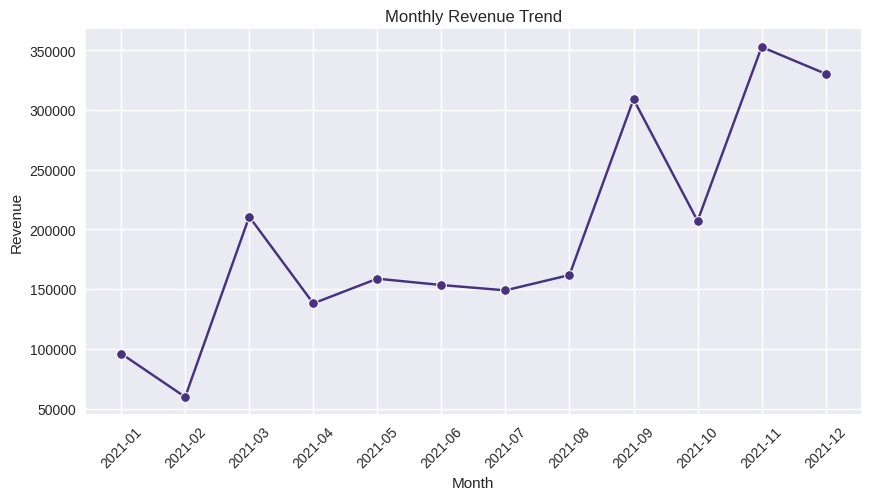

In [7]:
query = """
SELECT strftime('%Y-%m', [Order Date]) AS Month, SUM(Sales) AS Revenue
FROM orders
GROUP BY Month
ORDER BY Month;
"""
monthly_revenue = pd.read_sql_query(query, conn)

# Plot
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_revenue, x="Month", y="Revenue", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Revenue Trend")
plt.show()


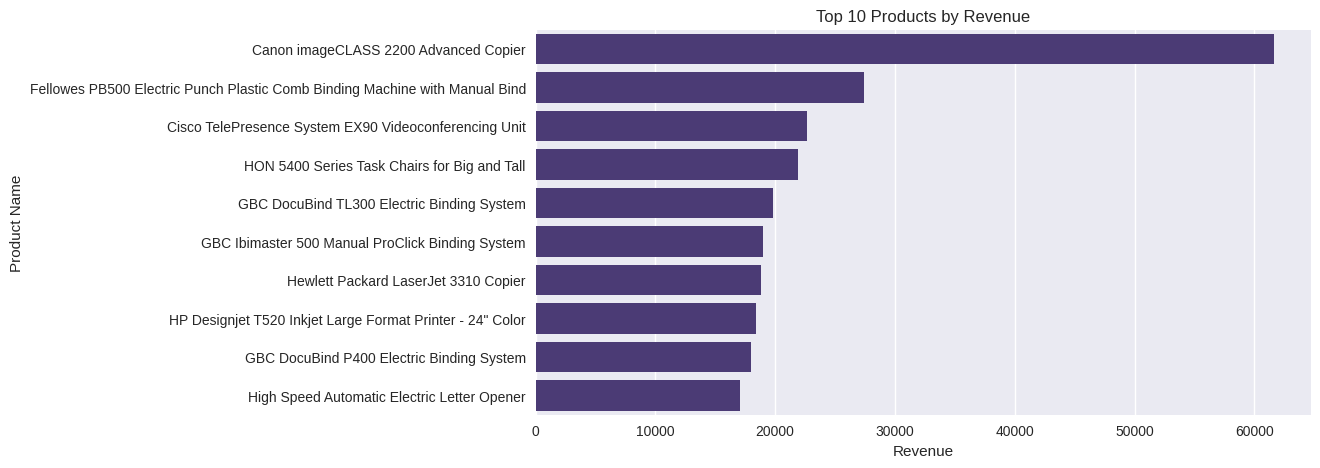

In [8]:
query = """
SELECT [Product Name], SUM(Sales) AS Revenue
FROM orders
GROUP BY [Product Name]
ORDER BY Revenue DESC
LIMIT 10;
"""
top_products = pd.read_sql_query(query, conn)

plt.figure(figsize=(10,5))
sns.barplot(data=top_products, x="Revenue", y="Product Name")
plt.title("Top 10 Products by Revenue")
plt.show()


In [9]:
query = """
SELECT [Customer ID], SUM(Sales) AS CLV
FROM orders
GROUP BY [Customer ID]
ORDER BY CLV DESC
LIMIT 10;
"""
clv = pd.read_sql_query(query, conn)
clv.head()


,Customer ID,CLV
0,SM-20320,25043.050
1,TC-20980,19052.218
2,RB-19360,15117.339
3,TA-21385,14595.620
4,AB-10105,14473.571


In [10]:
query = """
WITH monthly AS (
    SELECT strftime('%Y-%m', [Order Date]) AS Month, SUM(Sales) AS Revenue
    FROM orders
    GROUP BY Month
)
SELECT Month,
       Revenue,
       LAG(Revenue) OVER (ORDER BY Month) AS PrevRevenue,
       ROUND(((Revenue - LAG(Revenue) OVER (ORDER BY Month)) * 100.0 /
              LAG(Revenue) OVER (ORDER BY Month)), 2) AS MoM_Growth
FROM monthly;
"""
mom_growth = pd.read_sql_query(query, conn)
mom_growth.head(10)


,Month,Revenue,PrevRevenue,MoM_Growth
0,2021-01,96069.5156,NaN,NaN
1,2021-02,59751.2514,96069.5156,-37.80
2,2021-03,210672.0868,59751.2514,252.58
3,2021-04,138098.7486,210672.0868,-34.45
4,2021-05,158765.0337,138098.7486,14.96
5,2021-06,153459.9973,158765.0337,-3.34
6,2021-07,149001.7130,153459.9973,-2.91
7,2021-08,161821.9150,149001.7130,8.60
8,2021-09,308883.6697,161821.9150,90.88
9,2021-10,207126.2567,308883.6697,-32.94


In [11]:
# Create Customers table
customers = df[['Customer ID', 'Customer Name', 'Region']].drop_duplicates()
customers.to_sql("customers", conn, if_exists="replace", index=False)

# Create Products table
products = df[['Product ID', 'Product Name', 'Category', 'Sub-Category']].drop_duplicates()
products.to_sql("products", conn, if_exists="replace", index=False)

# Example JOIN: Customer sales with product categories
query = """
SELECT c.[Customer Name], p.Category, SUM(o.Sales) AS TotalSales
FROM orders o
JOIN customers c ON o.[Customer ID] = c.[Customer ID]
JOIN products p ON o.[Product ID] = p.[Product ID]
GROUP BY c.[Customer Name], p.Category
ORDER BY TotalSales DESC
LIMIT 10;
"""
join_example = pd.read_sql_query(query, conn)
join_example


,Customer Name,Category,TotalSales
0,Sean Miller,Technology,93926.032
1,Tamara Chand,Technology,71991.800
2,Raymond Buch,Technology,57061.664
3,Sanjit Chand,Office Supplies,48325.032
4,Adrian Barton,Office Supplies,45957.024
5,Christopher Conant,Technology,45289.272
6,Sanjit Engle,Technology,37407.960
7,Bill Shonely,Technology,36427.320
8,Peter Fuller,Furniture,35365.072
9,Hunter Lopez,Technology,34922.430


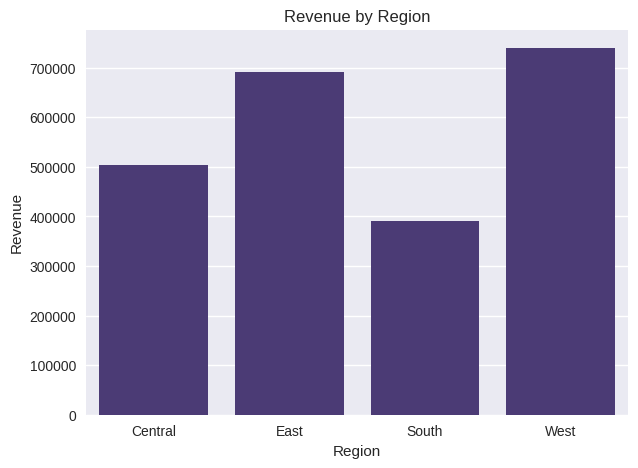

In [12]:
query = """
SELECT Region, SUM(Sales) AS Revenue
FROM orders
GROUP BY Region;
"""
region_sales = pd.read_sql_query(query, conn)

plt.figure(figsize=(7,5))
sns.barplot(data=region_sales, x="Region", y="Revenue")
plt.title("Revenue by Region")
plt.show()


In [13]:
# Save cleaned dataset for Power BI
df.to_csv("Cleaned_Superstore.csv", index=False)
